In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

In [ ]:
df = pd.read_csv('/content/tic_tac_toe_dataset.csv')

In [ ]:
df.head(2)

,top_left_square,top_middle_square,top_right_square,middle_left_square,middle_middle_square,middle_right_square,bottom_left_square,bottom_middle_square,bottom_right_square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive


### Data Exploration and Preprocessing

In [ ]:
df['class'].value_counts()

positive    626
negative    332
Name: class, dtype: int64

In [ ]:
#check for missing values
df.isna().sum()

top_left_square         0
top_middle_square       0
top_right_square        0
middle_left_square      0
middle_middle_square    0
middle_right_square     0
bottom_left_square      0
bottom_middle_square    0
bottom_right_square     0
class                   0
dtype: int64

In [ ]:
#Unique values for each column
for col in df:
    print(df[col].unique())

['x' 'o' 'b']
['x' 'o' 'b']
['x' 'o' 'b']
['x' 'o' 'b']
['o' 'b' 'x']
['o' 'b' 'x']
['x' 'o' 'b']
['o' 'x' 'b']
['o' 'x' 'b']
['positive' 'negative']


There are no possible outliers, as values in columns only consists of 3 unique categorical values.

In [ ]:
df_dummies = pd.get_dummies(df)
df_dummies

,top_left_square_b,top_left_square_o,top_left_square_x,top_middle_square_b,top_middle_square_o,top_middle_square_x,top_right_square_b,top_right_square_o,top_right_square_x,middle_left_square_b,...,bottom_left_square_o,bottom_left_square_x,bottom_middle_square_b,bottom_middle_square_o,bottom_middle_square_x,bottom_right_square_b,bottom_right_square_o,bottom_right_square_x,class_negative,class_positive
0,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
1,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
2,0,0,1,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,1
3,0,0,1,0,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
4,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,0,1,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
954,0,1,0,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0
955,0,1,0,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0
956,0,1,0,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0


In [ ]:
#splitting data into fetures and target, using get_dummies to convert categorical values
df_dummies = pd.get_dummies(df)
X_dummies = df_dummies.drop(columns=['class_negative', 'class_positive'])
y_dummies  = df_dummies['class_positive']

In [ ]:
#encoding all features and columns by replacing categorical values with numerical
df.replace(['x', 'o', 'b'], [0, 1, 2], inplace=True)
df.replace(['negative', 'positive'], [0, 1], inplace=True)
#splitting data into fetures and target
X = df.drop(columns='class')
y = df['class']

Exploring correlation matrixes

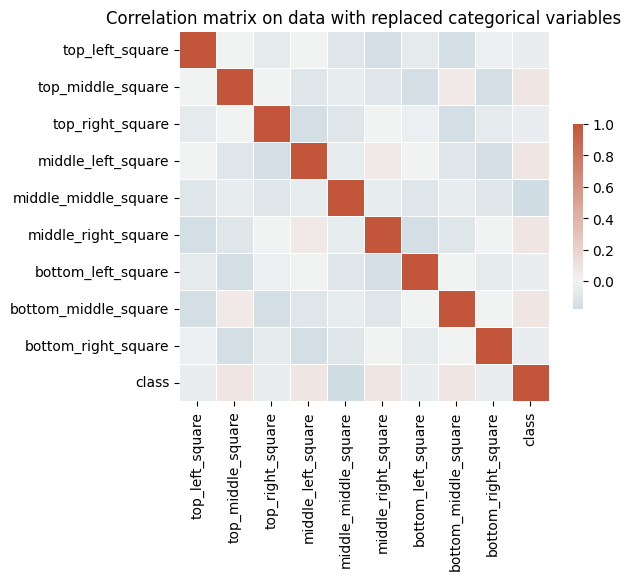

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix on data with replaced categorical variables')
plt.show()

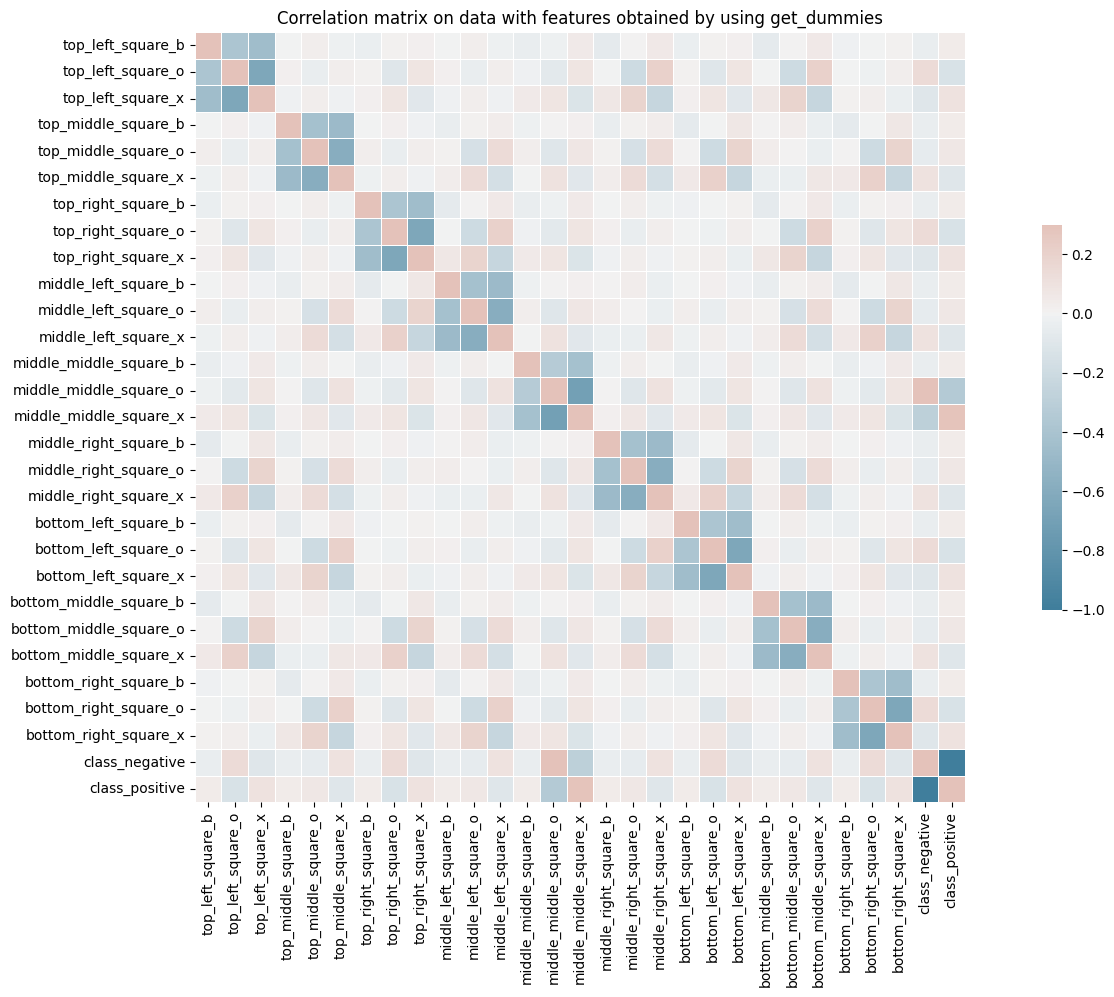

In [ ]:
plt.figure(figsize=(20,10))
corr = df_dummies.corr()
sns.heatmap(corr,cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix on data with features obtained by using get_dummies')
plt.show()

### Random Forest

In [ ]:
#function search through provided hyperparameters values and fits models
#saving achived evaluation metrics and hyperparameters of best model
def fit_rf(X, y):
  n_estimators = [50, 100, 150, 200]
  max_depth = [6, 9, 12, 15]
  min_samples_split = [2, 4, 8, 12]
  number_of_splits = 5

  best_params = {}
  best_mean_score = 0.0
  accuracies = []

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  #searching hyperparameters
  for estimators in n_estimators:
    for depth in max_depth:
      for samples_split in min_samples_split:
        
        clf = RandomForestClassifier(n_estimators=estimators, 
                                  max_depth=depth, 
                                  min_samples_split=samples_split)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        #calculating results
        balanced_score = balanced_accuracy_score(y_test, y_pred)
        score = clf.score(X_test, y_test)
        mean_score = (balanced_score + score) / 2
        accuracies.append(mean_score)
        #saving best hyperparameters and results
        if  mean_score > best_mean_score:
          best_mean_score = mean_score
          best_params['n_estimators'] = estimators
          best_params['max_depth'] = depth
          best_params['min_samples_split'] = samples_split
          conf_matrix = confusion_matrix(y_test, y_pred)
          classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])

  print(f'Mean of accuracy and balanced accuracy on the test data: {best_mean_score* 100:.2f}%') 
  print(f'Best hyperparameters found in the process: {best_params}')
  print(f'classification report:\n {classification_rep}')
  return conf_matrix, accuracies, best_params

In [ ]:
#confusion matrix and accuracy with respect to hyperparameters setting
def plot_results(conf_matrix, accuracies, hyperparameter=None):
  plt.figure(figsize=(12,6))
  tmp_df = pd.DataFrame(conf_matrix, index = ['negative', 'positive'],
                    columns = ['negative', 'positive'])
  plt.subplot(1,2,1)
  sns.heatmap(tmp_df / np.sum(conf_matrix), annot=True, cmap=cmap, fmt='.2%')
  plt.title('confusion matrix')

  
  #When using KNN, it plots accuracy with respect to n_neighbors
  #else only accuracies with respect to current iteration of search
  if hyperparameter is not None:
    plt.plot(hyperparameter, accuracies)
  if len(accuracies) <= 1:
    print('Not enough accuracy to plot the results')
  else:
    plt.subplot(1,2,2)
    plt.plot(accuracies)
    plt.title('Mean accuracy in each hyperparameters settings')
    plt.ylabel('Accuracy')
    plt.show()

Mean of accuracy and balanced accuracy on the test data: 97.10%
Best hyperparameters found in the process: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 2}
classification report:
               precision    recall  f1-score   support

    negative       0.99      0.94      0.96        72
    positive       0.97      0.99      0.98       120

    accuracy                           0.97       192
   macro avg       0.98      0.97      0.97       192
weighted avg       0.97      0.97      0.97       192

f1-score obtained using cross validation on best hyperparameters setting
0.8332191152914398


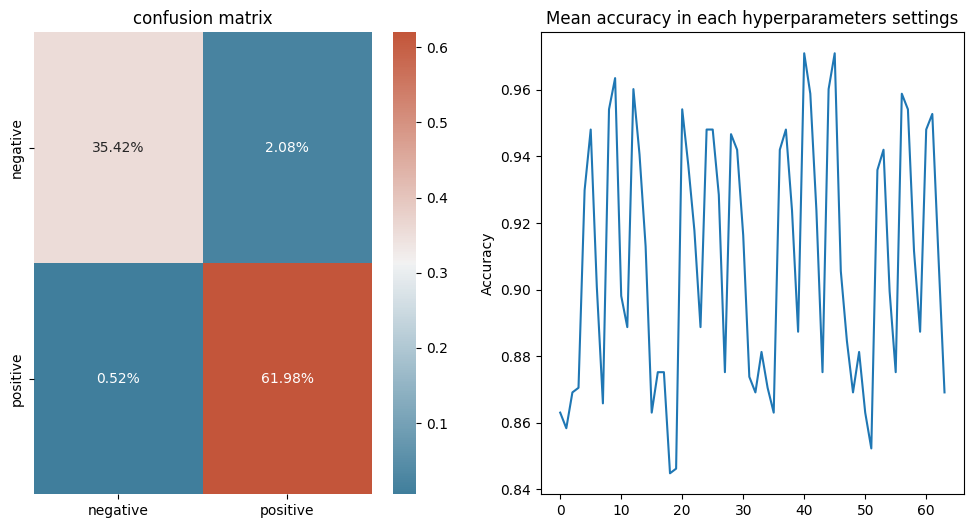

In [ ]:
start_time_rf = time.time()
conf_matrix, accuracies, best_params = fit_rf(X, y)
end_time_rf = time.time()
clf = RandomForestClassifier(**best_params)
score = cross_validate(clf, X, y, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

Mean of accuracy and balanced accuracy on the test data: 98.92%
Best hyperparameters found in the process: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 2}
classification report:
               precision    recall  f1-score   support

    negative       0.99      0.99      0.99        71
    positive       0.99      0.99      0.99       121

    accuracy                           0.99       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192

f1-score obtained using cross validation on best hyperparameters setting
0.8862354342749832


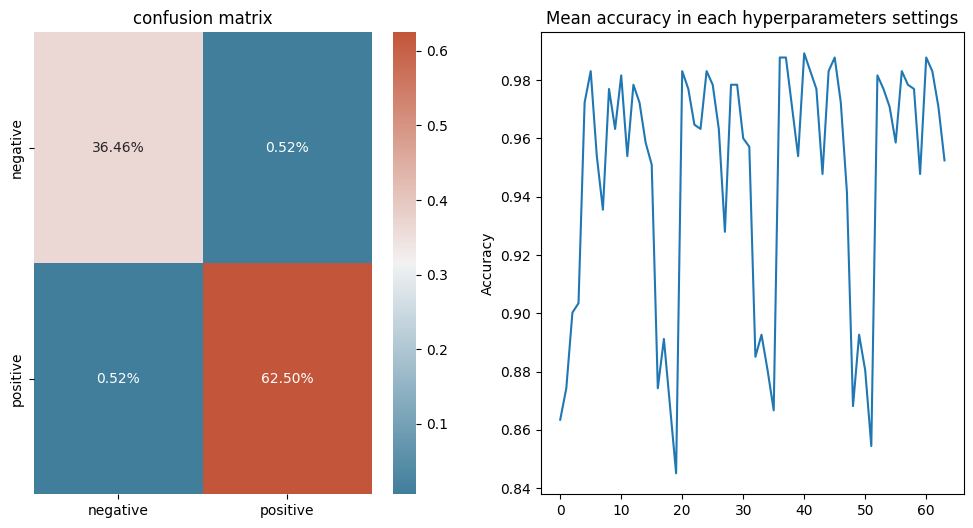

In [ ]:
conf_matrix, accuracies, best_params = fit_rf(X_dummies, y_dummies)

clf = RandomForestClassifier(**best_params)
score = cross_validate(clf, X_dummies, y_dummies, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

It looks like random forest is really sensetive to hyperparameters values, as the combined accuracy with balanced accuracy varies more than 20 percentage points.

### NaiveBayes

As NaiveBayes does not have a lot of hyperparameters to tune, in this case the default settings provided by the sklearn will be used.

In [ ]:
#fits model and return results
from sklearn.naive_bayes import GaussianNB
def fit_NB(X, y):
  accuracies = []
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  clf = GaussianNB()

  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  balanced_score = balanced_accuracy_score(y_test, y_pred)
  score = clf.score(X_test, y_test)
  mean_score = (balanced_score + score) / 2
  accuracies.append(mean_score)
  conf_matrix = confusion_matrix(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
  print(f'Mean of accuracy and balanced accuracy on the test data: {mean_score* 100:.2f}%') 
  print(f'classification report:\n {classification_rep}')
  return conf_matrix, accuracies

Mean of accuracy and balanced accuracy on the test data: 60.45%
classification report:
               precision    recall  f1-score   support

    negative       0.65      0.15      0.25        71
    positive       0.66      0.95      0.78       121

    accuracy                           0.66       192
   macro avg       0.65      0.55      0.51       192
weighted avg       0.65      0.66      0.58       192

f1-score obtained using cross validation on best hyperparameters setting
0.7018278294818281
Not enough accuracy to plot the results


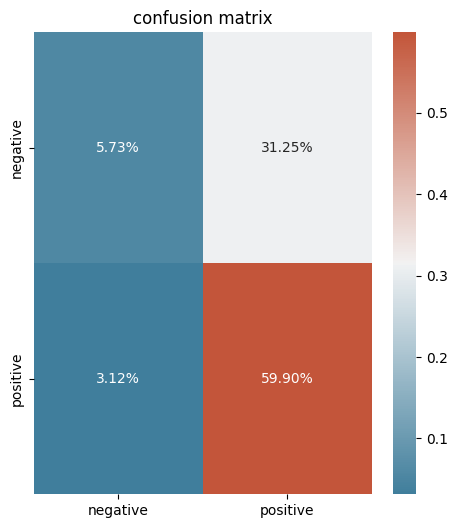

In [ ]:
start_time_NB = time.time()
conf_matrix, accuracies = fit_NB(X, y)
end_time_NB = time.time()
clf = GaussianNB()
score = cross_validate(clf, X, y, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

Mean of accuracy and balanced accuracy on the test data: 65.06%
classification report:
               precision    recall  f1-score   support

    negative       0.54      0.45      0.49        66
    positive       0.74      0.79      0.76       126

    accuracy                           0.68       192
   macro avg       0.64      0.62      0.63       192
weighted avg       0.67      0.68      0.67       192

f1-score obtained using cross validation on best hyperparameters setting
0.7205124322808911
Not enough accuracy to plot the results


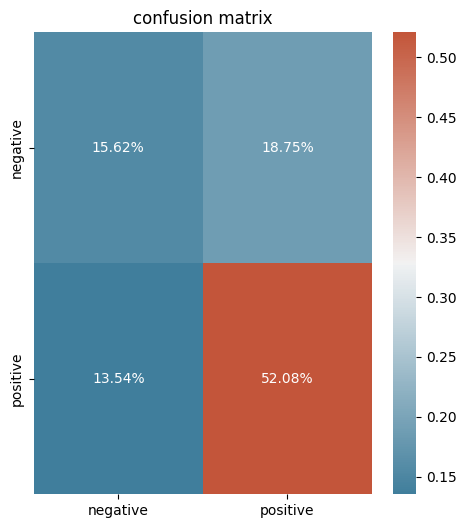

In [ ]:
conf_matrix, accuracies = fit_NB(X_dummies, y_dummies)

clf = CategoricalNB()
score = cross_validate(clf, X_dummies, y_dummies, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

### KNeighborsClassifier

The most import hyperparameter in KNeighborsClassifier is n_neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def fit_KNN(X, y):
  n_neighbors = np.arange(2, 20, 2)
  best_params = {}
  best_mean_score = 0.0
  mean_score = 0.0
  accuracies = []
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

  for neighbors in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors = neighbors)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    score = clf.score(X_test, y_test)
    mean_score = (balanced_score + score) / 2
    accuracies.append(mean_score)
    if  mean_score > best_mean_score:
      best_mean_score = mean_score
      best_params['neighbors'] = neighbors
      conf_matrix = confusion_matrix(y_test, y_pred)
      classification_rep = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
  print(f'Mean of accuracy and balanced accuracy on the test data: {best_mean_score* 100:.2f}%') 
  print(f'classification report:\n {classification_rep}')
  return conf_matrix, accuracies, n_neighbors

Mean of accuracy and balanced accuracy on the test data: 82.49%
classification report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.75        67
    positive       0.83      0.96      0.89       125

    accuracy                           0.85       192
   macro avg       0.86      0.80      0.82       192
weighted avg       0.86      0.85      0.84       192

f1-score obtained using cross validation on best hyperparameters setting
0.7756663809512175


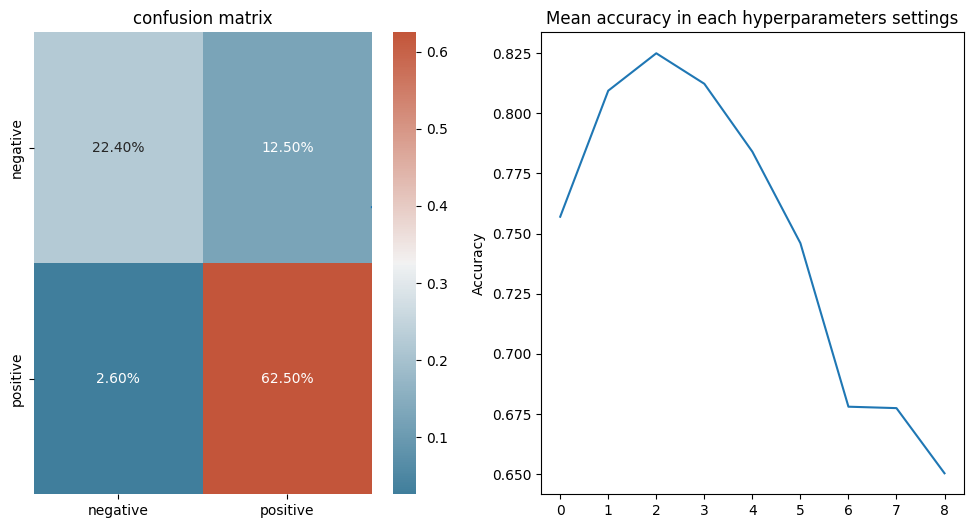

In [ ]:
start_time_KNN = time.time()
conf_matrix, accuracies, n_neighbors = fit_KNN(X, y)
end_time_KNN = time.time()
n_neighbors_cv = n_neighbors[np.argmax(accuracies)]
clf = KNeighborsClassifier(n_neighbors=n_neighbors_cv)
score = cross_validate(clf,X,y,cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies, n_neighbors)

Mean of accuracy and balanced accuracy on the test data: 99.34%
classification report:
               precision    recall  f1-score   support

    negative       1.00      0.98      0.99        62
    positive       0.99      1.00      1.00       130

    accuracy                           0.99       192
   macro avg       1.00      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192

f1-score obtained using cross validation on best hyperparameters setting
0.8615727301430075


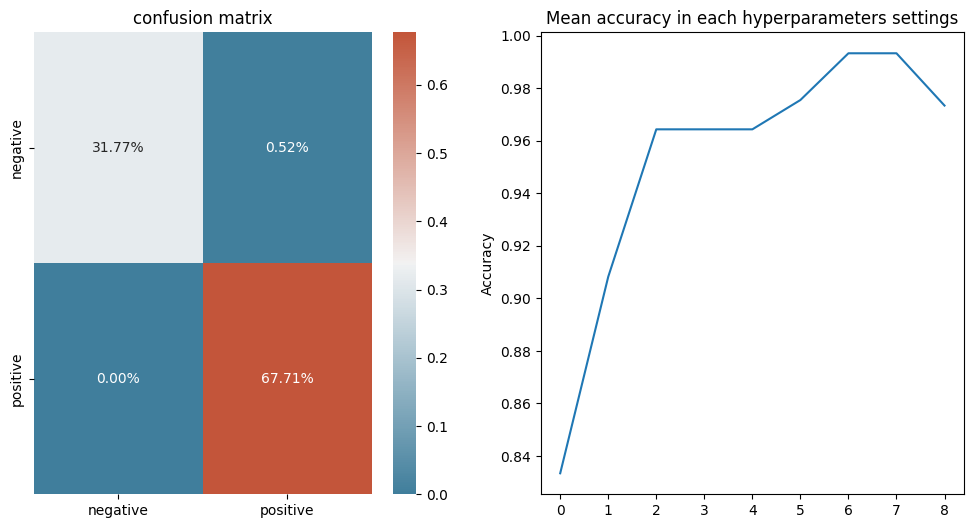

In [ ]:
conf_matrix, accuracies, n_neighbors = fit_KNN(X_dummies, y_dummies)
n_neighbors_cv = n_neighbors[np.argmax(accuracies)]
clf = KNeighborsClassifier(n_neighbors=n_neighbors_cv)
score = cross_validate(clf, X_dummies, y_dummies, cv=5, scoring='f1')
print(f'f1-score obtained using cross validation on best hyperparameters setting')
print(score['test_score'].mean())

plot_results(conf_matrix, accuracies)

In [ ]:
#number of hyperparameter searches in random forests
number_of_rf_trained = 4*4*4
print('Time for training and testing single random forest', ((end_time_rf - start_time_rf) / number_of_rf_trained))
print('Time for training and testing single Naive Bayes', end_time_NB - start_time_NB)
print('Time for training and testing single k-nearest neighbors', end_time_KNN - start_time_KNN)

Time for training and testing single random forest 0.3628643974661827
Time for training and testing single Naive Bayes 0.018618106842041016
Time for training and testing single k-nearest neighbors 0.17004704475402832


### Summary

* there is a significant difference between training models on differently preprocessed data. Models achieved better results after training on data where categorical data was transformed using 'get_dummies'

* naive Bayes performed much worse than Random Forest or k-Nearest Neighbors

* the algorithms were sensitive to hyperparameters, resulting in changes in measured accuracy more than 10 percentage points

* cross validation did not make significant performance increase, but the results are more more certain due to lack of randomness in the data split
 